# Используемые библиотеки

In [36]:
import gc # сборщик мусора

import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
%matplotlib inline
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from sklearn.preprocessing import StandardScaler, RobustScaler

import catboost as catb

from catboost import Pool,cv

#https://www.kaggle.com/camnugent/geospatial-feature-engineering-and-visualization

1) Заготовка 
2) Выгрузка данных
3) Обучение и тренировка
4) Работа с данными

# Функции, используемые в коде

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def nan_analize(X):
    nan_df = (X.isna().sum() / X.shape[0]).reset_index()
    nan_df.columns=['feature', 'nan_percent']

    plt.figure(figsize=(16,4))
    sns.barplot(nan_df['feature'], nan_df['nan_percent'])
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [4]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 5)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [5]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()

# Загрузка данных

In [46]:
df = pd.read_csv('Data set to train.csv')
df.head()

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,5088,-118.28,33.98,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN,121400.0
1,17096,-122.23,37.46,33.0,2643.0,464.0,1015.0,427.0,4.2232,NEAR OCEAN,363700.0
2,5617,-118.26,33.79,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN,205600.0
3,20060,-119.26,35.87,24.0,1590.0,390.0,1686.0,372.0,1.6469,INLAND,47600.0
4,895,-121.96,37.54,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN,236000.0


In [47]:
df.columns

Index(['Id ', 'longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'median_house_value'],
      dtype='object')

In [48]:
X = df.drop('median_house_value', axis=1)
y = df[['Id ', 'median_house_value']]

X_final = pd.read_csv('Data set to test X.csv')

X.set_index('Id ', inplace=True)
X_final.set_index('Id ', inplace=True)
y.set_index('Id ', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 13828
Строк в тесте 6812


56573

In [49]:
final_index_list = X_final.index

In [9]:
X = reduce_mem_usage(X)

Memory usage of dataframe is 1.05 MB
Memory usage after optimization is: 0.54 MB
Decreased by 48.7%


In [10]:
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 0.52 MB
Memory usage after optimization is: 0.27 MB
Decreased by 48.7%


# Смотрим данные

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

In [10]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
5088,-118.28,33.98,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN
17096,-122.23,37.46,33.0,2643.0,464.0,1015.0,427.0,4.2232,NEAR OCEAN
5617,-118.26,33.79,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN
20060,-119.26,35.87,24.0,1590.0,390.0,1686.0,372.0,1.6469,INLAND
895,-121.96,37.54,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN


In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13828 entries, 5088 to 15795
Data columns (total 8 columns):
longitude             13828 non-null float64
latitude              13828 non-null float64
housing_median_age    13349 non-null float64
total_rooms           13828 non-null float64
total_bedrooms        13828 non-null float64
population            13429 non-null float64
households            13828 non-null float64
median_income         13828 non-null float64
dtypes: float64(8)
memory usage: 1.6 MB


In [11]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [12]:
X.shape

(13828, 9)

In [13]:
X[['longitude', 'latitude']].head(2)

,longitude,latitude
Id,,
5088,-118.28,33.98
17096,-122.23,37.46


In [14]:
X[(X['longitude'] < 120) & (X['latitude'] < 34)].head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
5088,-118.28,33.98,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN
5617,-118.26,33.79,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN


## Количественные переменные

In [15]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,13828.000000,13828.000000,13349.000000,13828.000000,13828.000000,13429.000000,13828.000000,13828.000000
mean,-119.489883,34.763235,28.569706,2647.567255,540.267139,1430.854271,501.675441,3.876745
std,4.857729,115.937671,12.582947,2171.663363,421.248573,1148.827206,383.639299,1.903102
min,-124.350000,-13534.030000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.810000,33.940000,18.000000,1455.000000,297.000000,791.000000,280.000000,2.568575
50%,-118.510000,34.270000,29.000000,2139.000000,437.000000,1168.000000,412.000000,3.538750
75%,-118.010000,37.720000,37.000000,3166.000000,648.000000,1732.000000,607.000000,4.756600
max,121.290000,1327.130000,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A1640E91C8>,
      dtype=object)

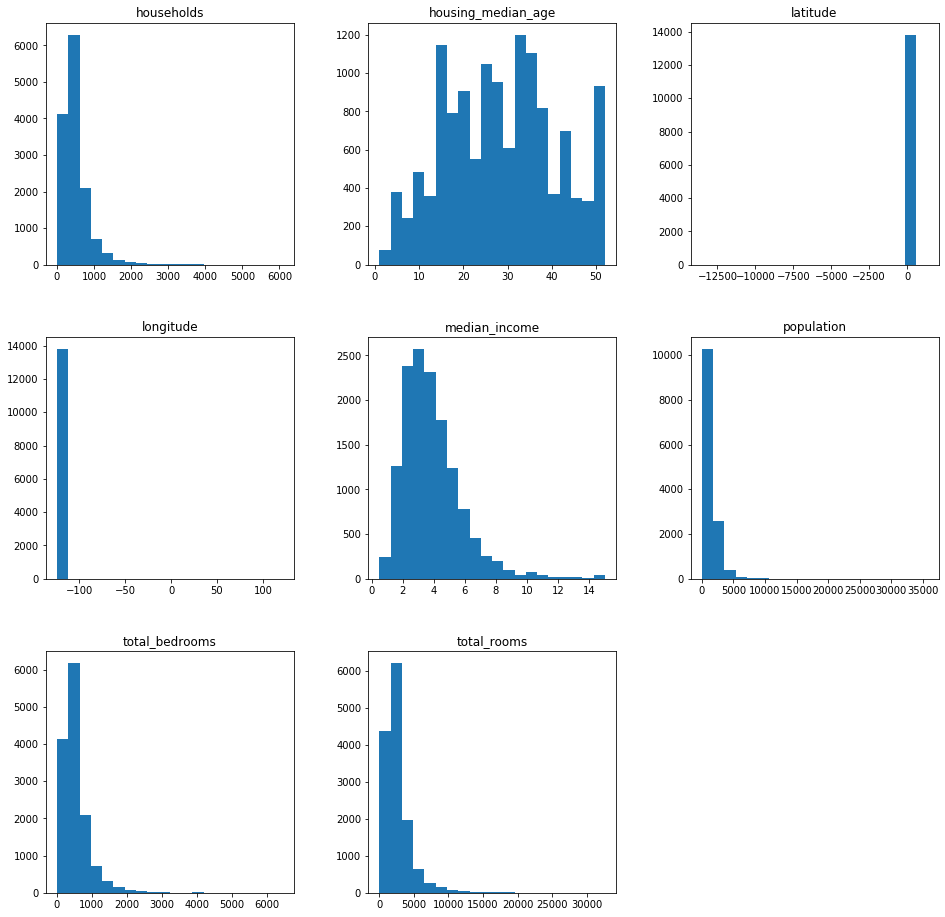

In [16]:
X.hist(figsize=(16,16), bins=20, grid=False)

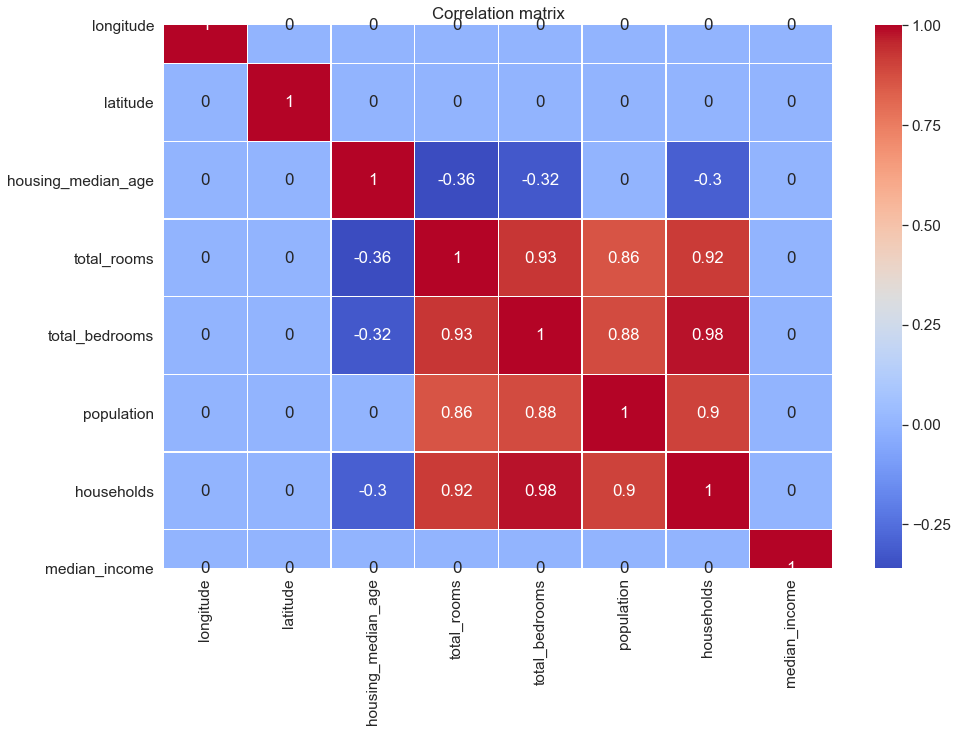

In [18]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # Проверьте, что будет если убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

C:\Anaconda\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Anaconda\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


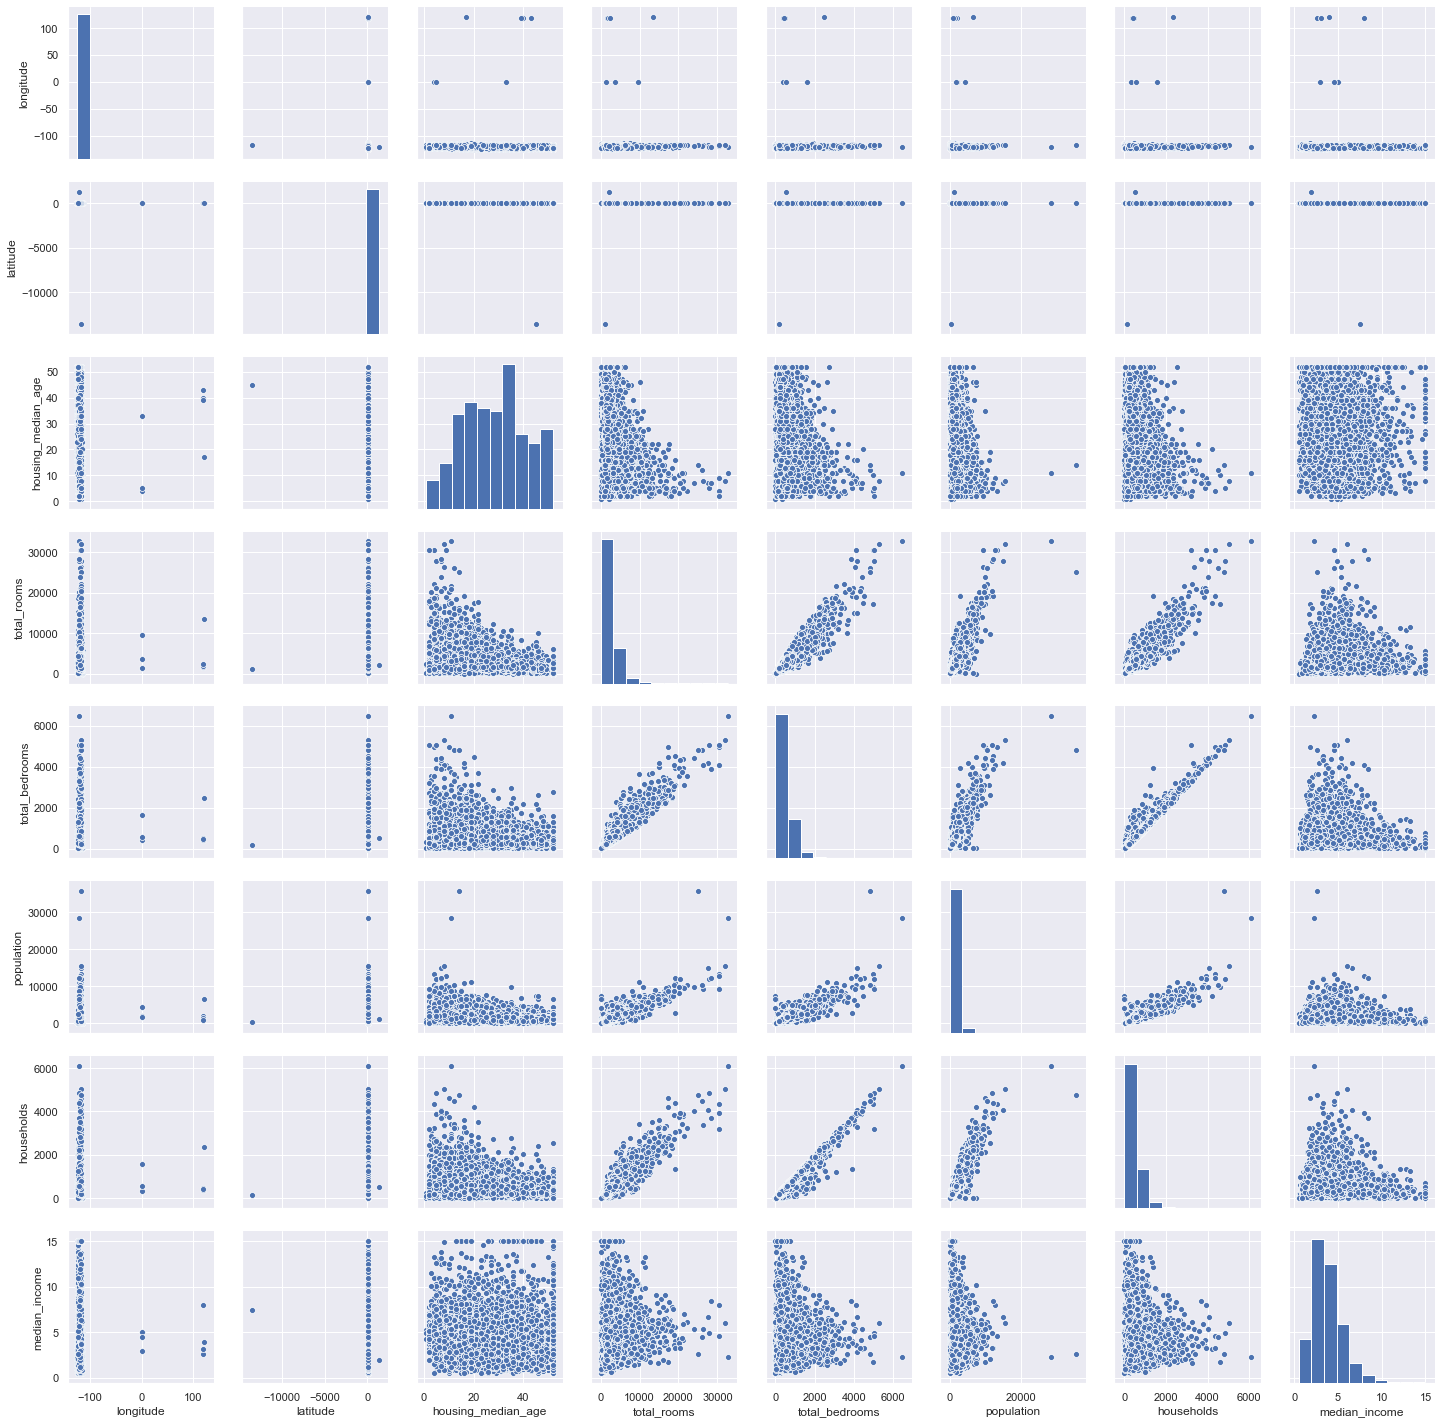

In [19]:
sns.set()
sns.pairplot(X, height = 2.5)
plt.show()

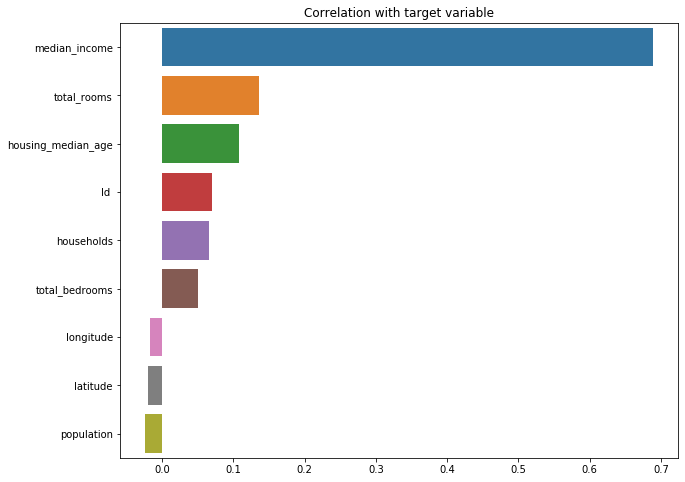

In [22]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

## Качественные переменные

In [20]:
X['ocean_proximity'].value_counts()

<1H OCEAN     6144
INLAND        4414
NEAR OCEAN    1702
NEAR BAY      1552
-               13
ISLAND           3
Name: ocean_proximity, dtype: int64

In [17]:
base_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity']

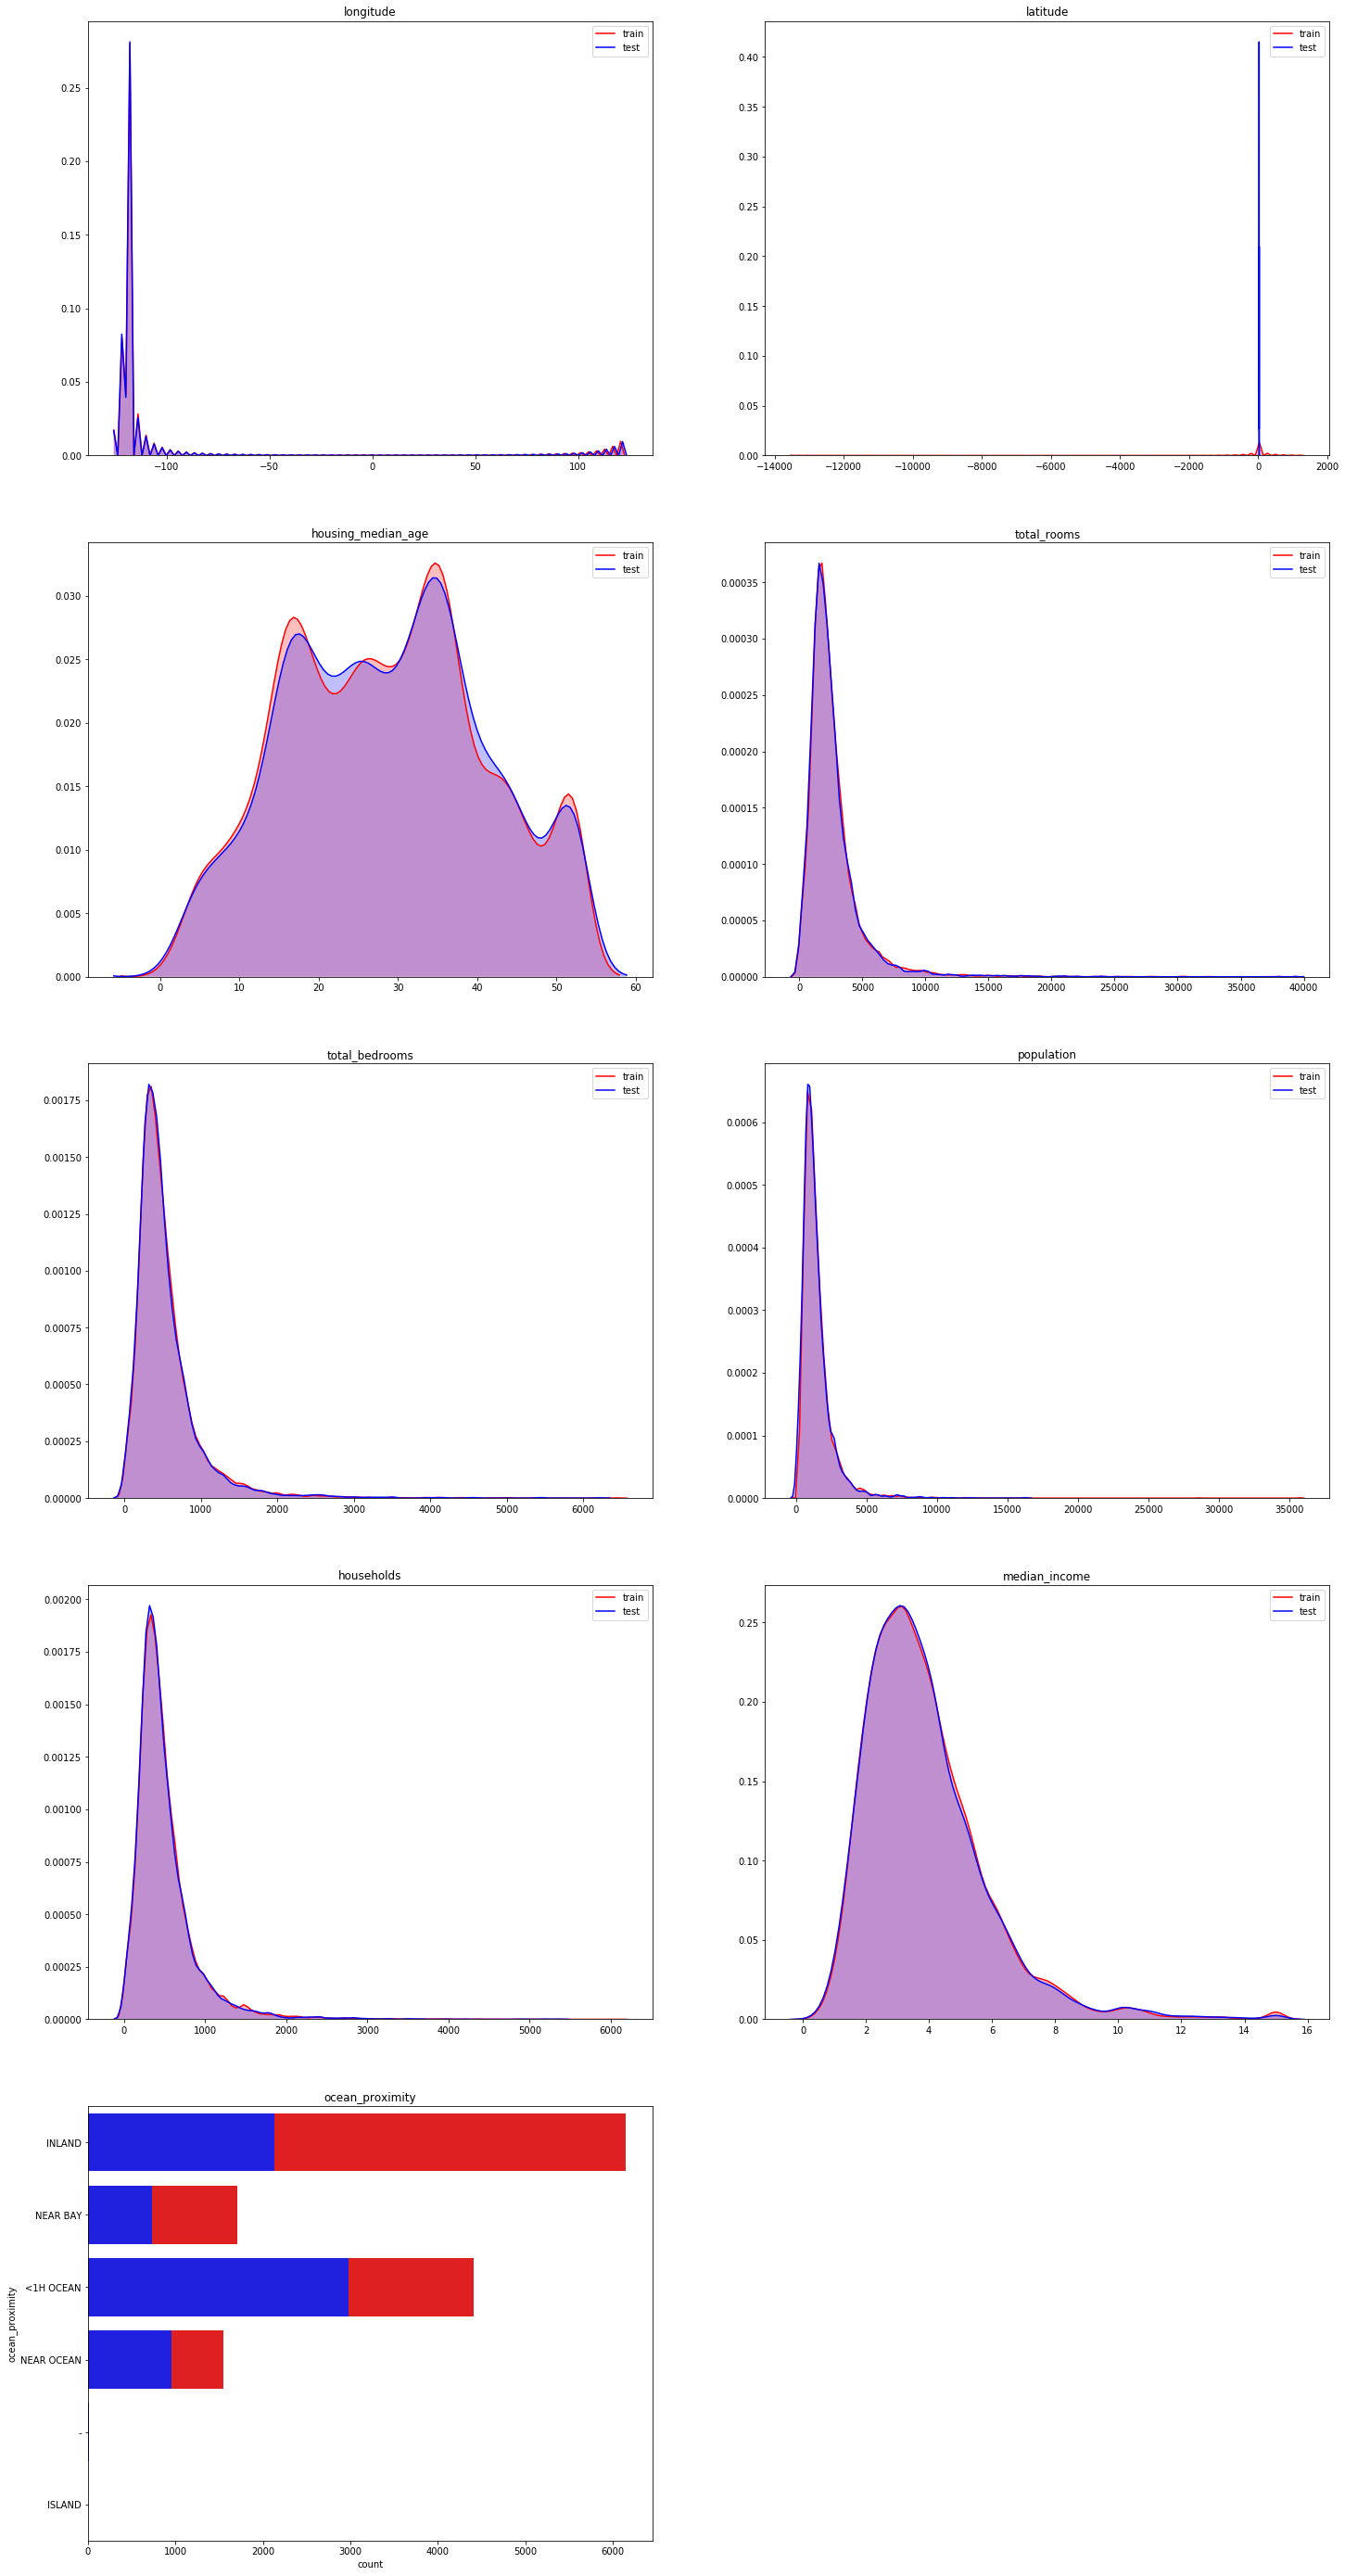

In [20]:
plt.figure(figsize = (24, 50))

l = len(base_features)

for i in range(l):
    plt.subplot((l+1)//2,2,i+1)
    plt.title(base_features[i])
    if X[base_features[i]].dtype == 'float64':
        sns.kdeplot(X[base_features[i]], shade=True, label='train', color='r')
        sns.kdeplot(X_final[base_features[i]], shade=True, label='test', color='b')
    else:
        sns.countplot(y=base_features[i], data=X, color = 'r')
        sns.countplot(y=base_features[i], data=X_final, color = 'b')

plt.show()
#for i in range(0, 5):
#  plt.subplot(5,2,i+1)

# Анализируем и исправляем

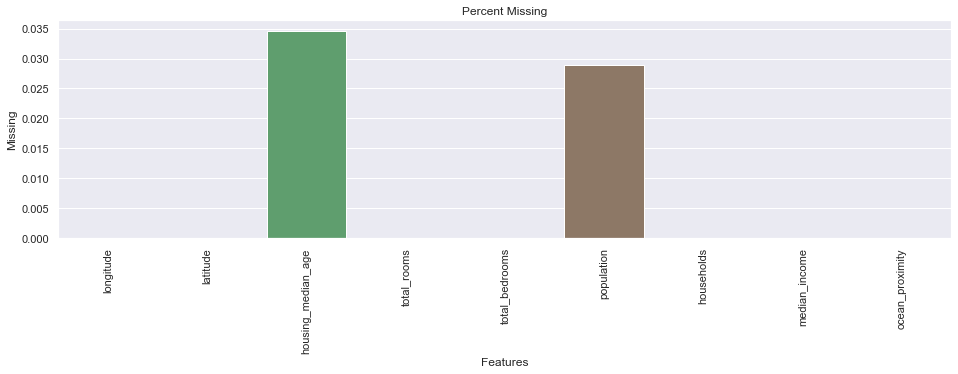

In [21]:
nan_analize(X)

In [ ]:
median = X['housing_median_age'].median()
X['housing_median_age'] = X['housing_median_age'].fillna(median)
X_final['housing_median_age'] = X_final['housing_median_age'].fillna(median)

In [ ]:
median = X['population'].median()
X['population'] = X['population'].fillna(median)
X_final['population'] = X_final['population'].fillna(median)


In [ ]:
# второе
X.loc[X['longitude'] > 0, 'longitude'] = X.loc[X['longitude'] > 0, 'longitude'] * -1
X_final.loc[X_final['longitude'] > 0, 'longitude'] = X_final.loc[X_final['longitude'] > 0, 'longitude'] * -1

In [ ]:
# третье
X.loc[X['longitude'] == 0, 'longitude'] = X['longitude'].median()
X_final.loc[X_final['longitude'] == 0, 'longitude'] = X_final['longitude'].median()

In [ ]:
# пятое
median = X['latitude'].median()
X.loc[X['latitude'] < 0, 'latitude'] = median
X_final.loc[X_final['latitude'] < 0, 'latitude'] = median

In [ ]:
# четвёртое
X = pd.concat([X, pd.get_dummies(X['ocean_proximity'])], axis=1)
X_final = pd.concat([X_final, pd.get_dummies(X_final['ocean_proximity'])], axis=1)

In [ ]:
# шестое
X['population_per_room'] = X['population'] / X['total_rooms']
X_final['population_per_room'] = X_final['population'] / X_final['total_rooms']

In [ ]:
X.loc[X['total_bedrooms'] > 25].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,median_income,-,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
Id,,,,,,,,,,,,,
5088,-118.28,33.98,19.0,883.0,313.0,726.0,0.9809,0,1,0,0,0,0
17096,-122.23,37.46,33.0,2643.0,464.0,1015.0,4.2232,0,0,0,0,0,1
5617,-118.26,33.79,42.0,1162.0,264.0,1044.0,3.5488,0,1,0,0,0,0
20060,-119.26,35.87,24.0,1590.0,390.0,1686.0,1.6469,0,0,1,0,0,0
895,-121.96,37.54,14.0,5106.0,1207.0,2738.0,3.9909,0,1,0,0,0,0


In [22]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

# Проверяем модель

In [26]:
remain_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']

X = X[remain_features]
X_final = X_final[remain_features]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
model = LGBMRegressor(max_depth=15,
                             min_samples_leaf=5,
                             n_estimators=150,
                             random_state=42)
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=15,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=5,
              min_split_gain=0.0, n_estimators=150, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

R2:	0.82121
RMSE:	48601.935
MSE:	2362148120.174


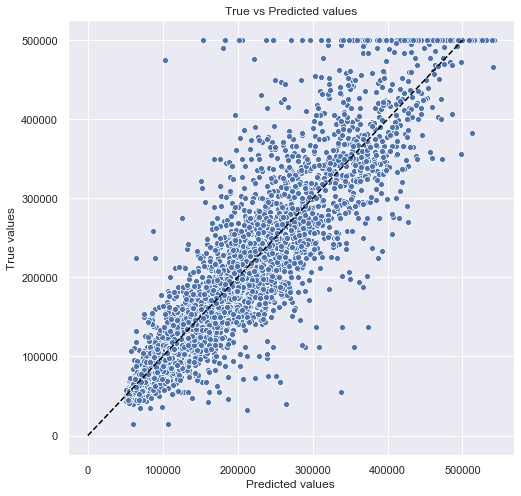

In [26]:
y_pred_test = model.predict(X_test)
#y_test.columns
evaluate_preds(y_test['median_house_value'], y_pred_test)

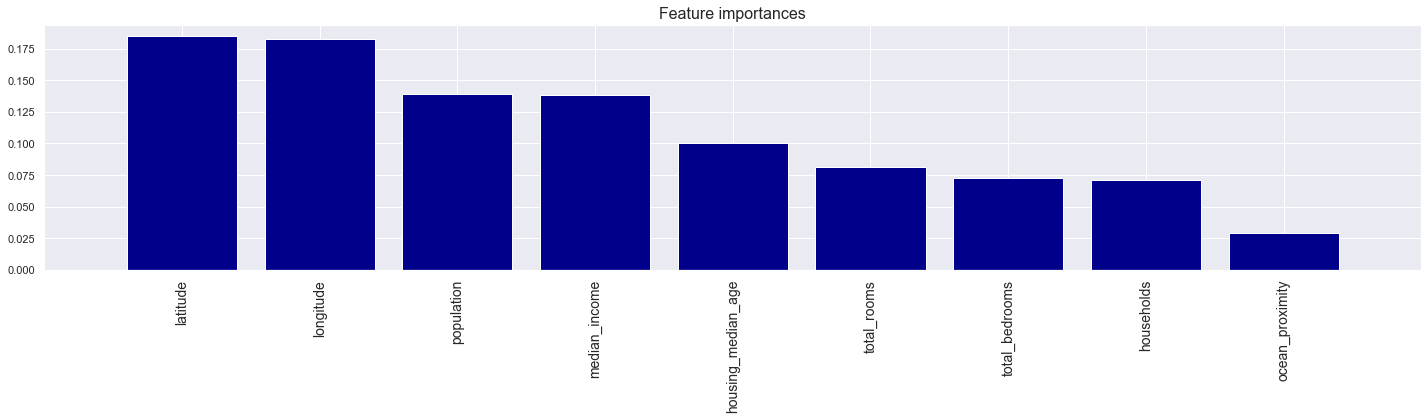

In [27]:
plot_feature_importances(importances = model.feature_importances_, X=X)

## Учим финальную модель

In [27]:
model_lgbm_f = LGBMRegressor(max_depth=15,
                             min_samples_leaf=5,
                             n_estimators=150,
                             random_state=42)
model_lgbm_f.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=15,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=5,
              min_split_gain=0.0, n_estimators=150, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [29]:
y_pred_test = model_lgbm_f.predict(X_final)
y_pred_test

array([ 63028.07688197,  78892.46206179, 445636.99310497, ...,
       126655.11598896, 135280.80806193, 340577.36892271])

In [32]:
y_pred_df = pd.DataFrame(y_pred_test, columns=['median_house_value'])

In [33]:
y_pred_df

,median_house_value
0,63028.076882
1,78892.462062
2,445636.993105
3,257445.837487
4,252176.596650
...,...
6807,165510.555928
6808,122721.162544
6809,126655.115989
6810,135280.808062


In [34]:
X_final.index

Int64Index([20046,  3024, 15663, 20484,  9814, 13311,  7113,  7668, 18246,
             5723,
            ...
             6557,  3383, 16201, 18186,  3592, 15316, 14772, 12870, 13476,
            16123],
           dtype='int64', name='Id ', length=6812)

In [35]:
filename = 'File.csv'
y_pred_df.to_csv(filename, index=None)

## Или берём другое

In [50]:
number_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']
cat_features = ['ocean_proximity']

In [ ]:
c_dataset = Pool(data=pd.concat([X_train, X_test], ignore_index=True),
                  label=pd.concat([y_train, y_test], ignore_index=True),
                  cat_features=cat_features)


params = {"iterations": 220,
          
          "max_depth":3,
          "eval_metric":"R2",
          "l2_leaf_reg":10.0,
          "loss_function": "Logloss",
          "colsample_bylevel":0.5,
          "verbose": False}
scores = cv(c_dataset,
            params,
            fold_count=3, 
            plot="True")

In [51]:
cat_features = []
for cat_colname in X.select_dtypes(include='object').columns:
    cat_features.append(cat_colname)
    
cat_features

['ocean_proximity']

In [54]:
model_catb_f_test = catb.CatBoostClassifier(silent=True, cat_features=cat_features, iterations = 219, eval_metric="R2", colsample_bylevel=0.5, max_depth=3)
model_catb_f_test.fit(X[number_features + cat_features], y)

CatBoostError: c:/program files (x86)/go agent/pipelines/buildmaster/catboost.git/catboost/private/libs/options/loss_description.cpp:381: metric [R2] is incompatible with loss [MultiClass] (no multiclass support)